<a href="https://colab.research.google.com/github/EricChan12311/DMA/blob/main/DataMining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tarfile
import urllib.request

In [2]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [3]:
# Load dataset.csv into the notebook.
data = pd.read_csv("dataset.csv")

In [ ]:
data.head()

,ID,travel_fee,departure_time,departure_long,departure_lat,arrival_long,arrival_lat,occupancy
0,2013-07-02 19:54:00.000000232,7.0,2013-07-02 19:54:00+00:00,-74.005360,40.728867,-74.008913,40.710907,1
1,2013-09-28 00:21:31.0000002,5.5,2013-09-28 00:21:31+00:00,-74.014165,40.708941,-74.016310,40.716734,1
2,2013-06-16 03:18:00.000000150,21.5,2013-06-16 03:18:00+00:00,-73.991075,40.760352,-73.941382,40.713292,1
3,2013-07-20 13:43:00.000000121,9.5,2013-07-20 13:43:00+00:00,-74.002662,40.723630,-73.991722,40.748905,5
4,2013-11-05 22:57:17.0000003,15.5,2013-11-05 22:57:17+00:00,-73.962397,40.712705,-73.996834,40.680403,2


# Split dataset into train set and test set


In [4]:
from sklearn.model_selection import train_test_split


train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

print("Length of train_set:", len(train_set))
print("Length of test_set:", len(test_set))

Length of train_set: 838860
Length of test_set: 209715


# Visualization of the Dataset (Done By: Chan Heng Hung)

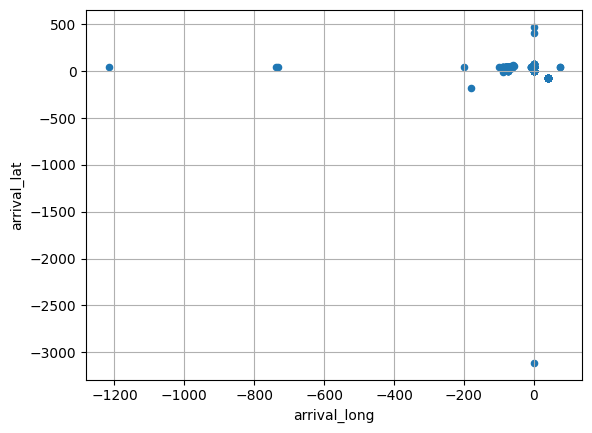

In [ ]:
train_set.plot(kind="scatter", x="arrival_long", y="arrival_lat", grid=True)
plt.show()

Text(0, 0.5, 'Count')

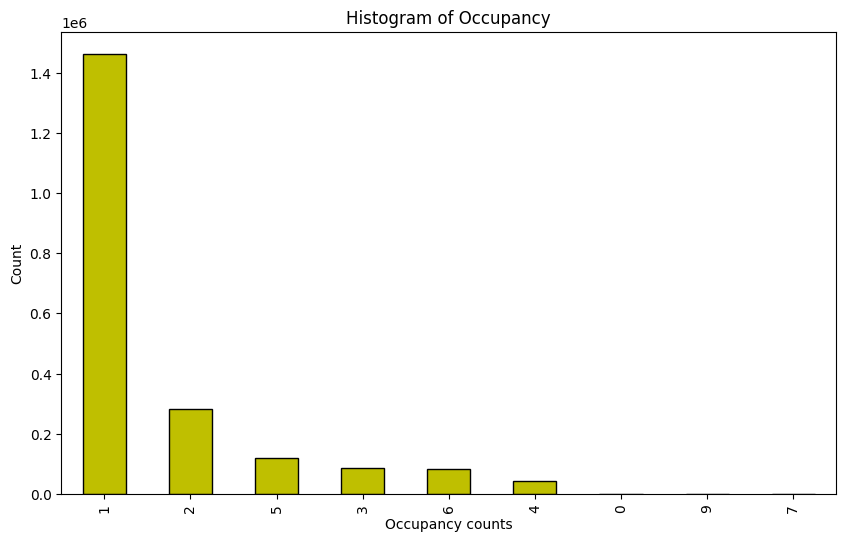

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,6))
train_set['occupancy'].value_counts().plot.bar(color = 'y', edgecolor = 'k');
plt.title('Histogram of Occupancy')
plt.xlabel('Occupancy counts')
plt.ylabel('Count')

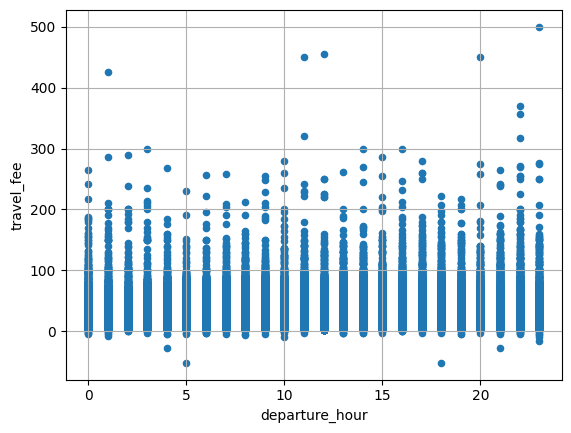

In [ ]:
train_set['departure_time'] = pd.to_datetime(train_set['departure_time'])
train_set['departure_hour'] = train_set['departure_time'].dt.hour
train_set.plot(kind="scatter", x="departure_hour", y="travel_fee", grid=True)
plt.show()

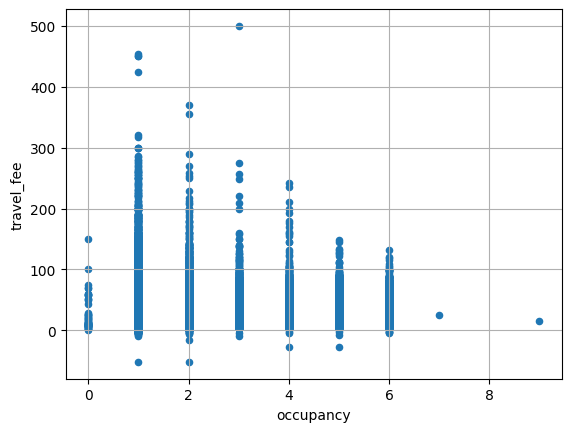

In [ ]:
train_set.plot(kind="scatter", x="occupancy", y="travel_fee", grid=True)
plt.show()

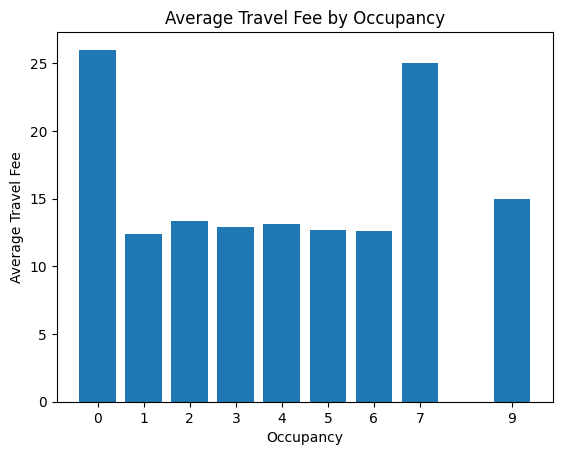

In [ ]:
average_fare_by_occupancy = train_set.groupby('occupancy')['travel_fee'].mean()

plt.bar(average_fare_by_occupancy.index, average_fare_by_occupancy.values)
plt.xlabel('Occupancy')
plt.ylabel('Average Travel Fee')
plt.title('Average Travel Fee by Occupancy')
plt.xticks(average_fare_by_occupancy.index)
plt.show()

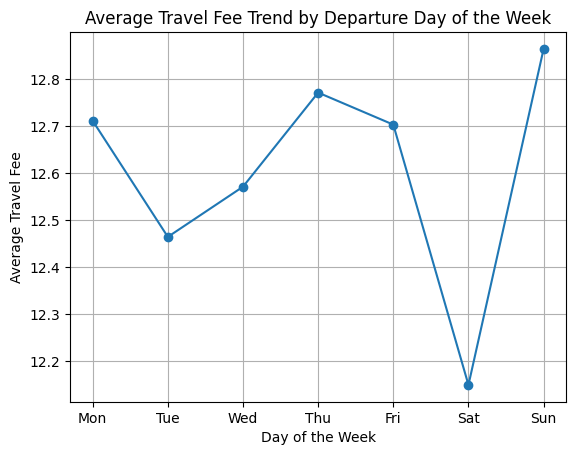

In [ ]:
train_set['day_of_week'] = train_set['departure_time'].dt.dayofweek
average_fare_by_dow = train_set.groupby('day_of_week')['travel_fee'].mean()

plt.plot(average_fare_by_dow.index, average_fare_by_dow.values, marker='o')
plt.xlabel('Day of the Week')
plt.ylabel('Average Travel Fee')
plt.title('Average Travel Fee Trend by Departure Day of the Week')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid()
plt.show()

# Correlation Between Attributes (Done By: Eason Chuah)




In [ ]:
corr_matrix = train_set.corr(numeric_only=True)
corr_matrix["travel_fee"].sort_values(ascending=False)

travel_fee        1.000000
arrival_long      0.021472
departure_long    0.020031
occupancy         0.011927
day_of_week      -0.000741
departure_lat    -0.014714
arrival_lat      -0.017451
departure_hour   -0.019204
Name: travel_fee, dtype: float64

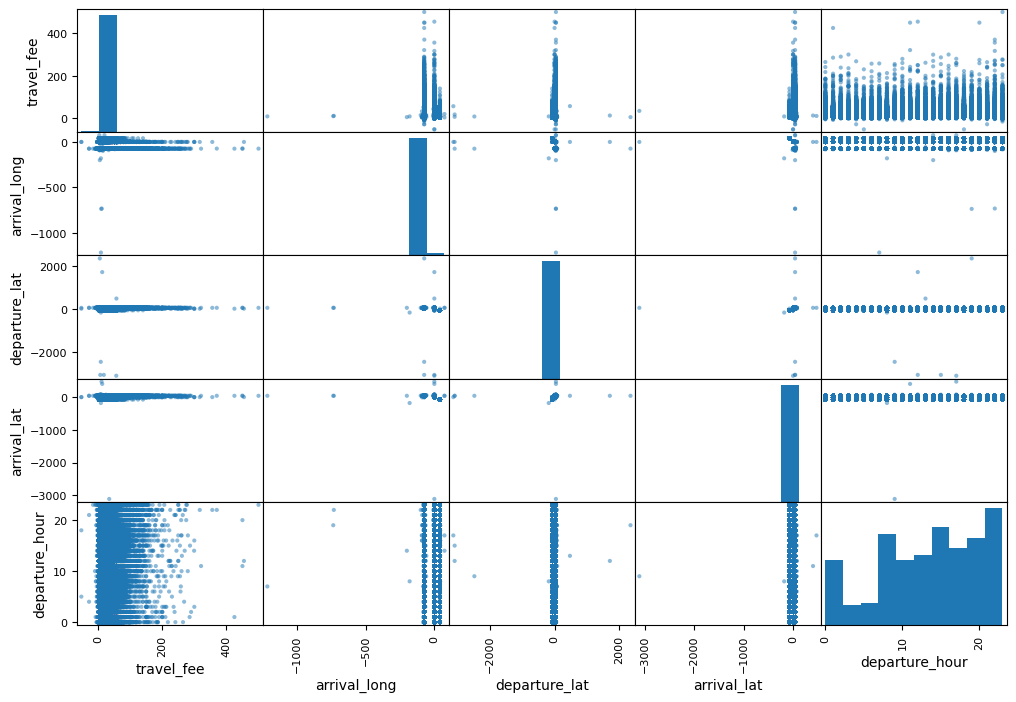

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["travel_fee", "arrival_long","departure_lat","arrival_lat","departure_hour"]
scatter_matrix(train_set[attributes], figsize=(12, 8))
plt.show()

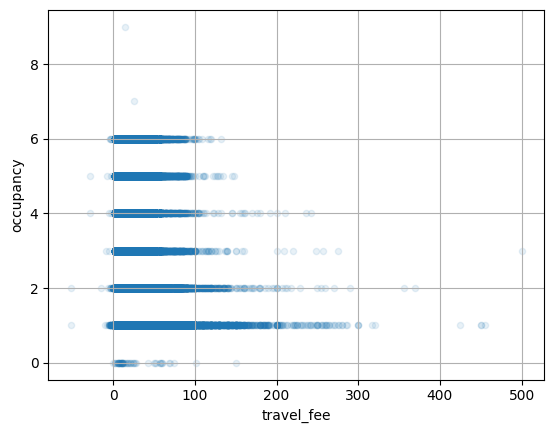

In [ ]:
train_set.plot(kind="scatter", x="travel_fee", y="occupancy", alpha=0.1, grid=True)
plt.show()

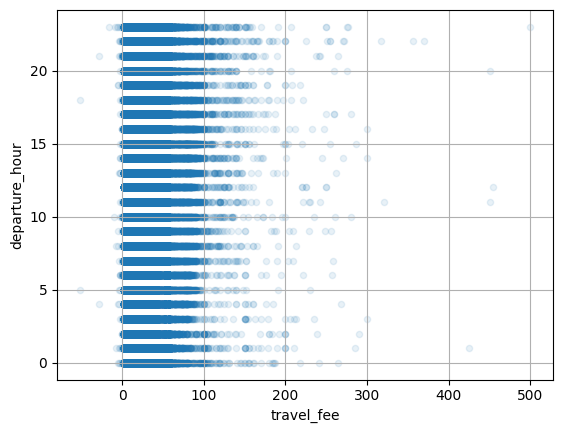

In [ ]:
train_set.plot(kind="scatter", x="travel_fee", y="departure_hour", alpha=0.1, grid=True)
plt.show()

#Query data in data frame

In [ ]:
import numpy as np

# Calculate distance
R = 6371
lat1, lon1, lat2, lon2 = map(np.radians, [train_set['departure_lat'], train_set['departure_long'], train_set['arrival_lat'], train_set['arrival_long']])
dlat = lat2 - lat1
dlon = lon2 - lon1
a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
train_set['distance'] = R * c

train_set['price_per_km'] = train_set['travel_fee'] / train_set['distance']
train_set['departure_time'] = pd.to_datetime(train_set['departure_time'])


In [ ]:
# 1. Month vs Price per km

train_set['month'] = train_set['departure_time'].dt.month

custom_bins = [-np.inf, 0, 10, 20, 30, 40, 50, 75, 100, np.inf]
pd.crosstab(index=train_set['month'], columns=pd.cut(train_set['price_per_km'], custom_bins), margins=True)

price_per_km,"(-inf, 0.0]","(0.0, 10.0]","(10.0, 20.0]","(20.0, 30.0]","(30.0, 40.0]","(40.0, 50.0]","(50.0, 75.0]","(75.0, 100.0]","(100.0, inf]",All
month,,,,,,,,,,
1,0,172172,237,106,76,36,63,39,5373,178102
2,0,162303,251,88,42,33,60,45,5146,167968
3,0,182502,228,109,59,37,61,37,5509,188542
4,0,175966,219,92,57,40,70,36,4728,181208
5,0,178569,263,102,65,36,62,30,4979,184106
6,0,167300,207,94,70,32,57,41,4526,172327
7,0,161659,216,94,50,36,51,22,3871,165999
8,84,146556,206,82,57,24,46,27,2984,150066
9,0,164687,259,107,63,33,54,36,3080,168319


In [ ]:
# 2. Day vs price_per_km (weekend and weekday)

train_set['day_of_week'] = train_set['departure_time'].dt.dayofweek
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
train_set['day_name'] = train_set['day_of_week'].map(lambda x: day_names[x])

custom_bins = [-np.inf, 0, 10, 20, 30, 40, 50, 75, 100, np.inf]
(pd.crosstab(index=train_set['day_name'], columns=pd.cut(train_set['price_per_km'], custom_bins), margins=True)
                  .loc[day_names])

price_per_km,"(-inf, 0.0]","(0.0, 10.0]","(10.0, 20.0]","(20.0, 30.0]","(30.0, 40.0]","(40.0, 50.0]","(50.0, 75.0]","(75.0, 100.0]","(100.0, inf]",All
day_name,,,,,,,,,,
Monday,9,261219,360,143,84,64,90,62,6696,268727
Tuesday,18,286042,373,160,87,71,95,56,7314,294216
Wednesday,5,291101,402,147,106,43,96,47,7585,299532
Thursday,15,299103,414,153,113,66,115,69,7860,307908
Friday,17,307658,478,208,108,64,96,72,8132,316833
Saturday,11,305145,443,193,108,62,103,70,7800,313935
Sunday,9,268298,374,150,107,71,105,61,6856,276031


In [ ]:
# 3. weekend and weekday vs price_per_km

train_set['day_type'] = train_set['departure_time'].apply(lambda x: 'Weekend' if x.weekday() >= 5 else 'Weekday')


custom_bins = [-np.inf, 0, 10, 20, 30, 40, 50, 75, 100, np.inf]
pd.crosstab(index=train_set['day_type'], columns=pd.cut(train_set['price_per_km'], custom_bins), margins=True)


price_per_km,"(-inf, 0.0]","(0.0, 10.0]","(10.0, 20.0]","(20.0, 30.0]","(30.0, 40.0]","(40.0, 50.0]","(50.0, 75.0]","(75.0, 100.0]","(100.0, inf]",All
day_type,,,,,,,,,,
Weekday,64,1445123,2027,811,498,308,492,306,37587,1487216
Weekend,20,573443,817,343,215,133,208,131,14656,589966
All,84,2018566,2844,1154,713,441,700,437,52243,2077182


In [ ]:
# 4. Period vs price_per_km

def return_period(hour):
    if 4 <= hour < 6:
        return 'Early Morning'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 20:
        return 'Evening'
    elif 20 <= hour < 24:
        return 'Night'
    else:
        return 'Midnight'

train_set['period_hour'] = train_set['departure_time'].dt.hour.apply(return_period)

custom_bins = [-np.inf, 0, 10, 20, 30, 40, 50, 75, 100, np.inf]
desired_order = ['Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night', 'Midnight']

(pd.crosstab(index=train_set['period_hour'], columns=pd.cut(train_set['price_per_km'], custom_bins), margins=True)
    .reindex(desired_order))

price_per_km,"(-inf, 0.0]","(0.0, 10.0]","(10.0, 20.0]","(20.0, 30.0]","(30.0, 40.0]","(40.0, 50.0]","(50.0, 75.0]","(75.0, 100.0]","(100.0, inf]",All
period_hour,,,,,,,,,,
Early Morning,6,43578,102,48,32,14,18,17,1365,45180
Morning,22,485704,700,264,158,100,165,108,12250,499471
Afternoon,10,474028,663,280,171,116,194,106,12535,488103
Evening,9,346264,448,197,126,68,102,67,8841,356122
Night,21,453044,541,218,131,88,132,71,11202,465448
Midnight,16,215948,390,147,95,55,89,68,6050,222858


In [ ]:
# 5.  Peak hour vs price_per_km (can know the peak hour)

train_set['hour'] = train_set['departure_time'].dt.hour
custom_bins = [-np.inf, 0, 10, 20, 30, 40, 50, 75, 100, np.inf]
pd.crosstab(index=train_set['hour'], columns=pd.cut(train_set['price_per_km'], custom_bins), margins=True)

price_per_km,"(-inf, 0.0]","(0.0, 10.0]","(10.0, 20.0]","(20.0, 30.0]","(30.0, 40.0]","(40.0, 50.0]","(50.0, 75.0]","(75.0, 100.0]","(100.0, inf]",All
hour,,,,,,,,,,
0,6,80670,132,48,26,15,32,17,2122,83068
1,5,59222,97,39,25,22,26,18,1624,61078
2,3,44105,85,31,19,4,17,18,1276,45558
3,2,31951,76,29,25,14,14,15,1028,33154
4,3,23386,61,29,24,7,13,6,731,24260
5,3,20192,41,19,8,7,5,11,634,20920
6,4,41582,65,25,20,8,15,10,1163,42892
7,4,73177,127,42,30,22,30,20,1843,75295
8,4,91417,128,62,28,28,35,22,2310,94034


In [ ]:
# 6. Occupancy vs price_per_km

custom_bins = [-np.inf, 0, 10, 20, 30, 40, 50, 75, 100, np.inf]
pd.crosstab(index=train_set['occupancy'], columns=pd.cut(train_set['price_per_km'], custom_bins), margins=True)


price_per_km,"(-inf, 0.0]","(0.0, 10.0]","(10.0, 20.0]","(20.0, 30.0]","(30.0, 40.0]","(40.0, 50.0]","(50.0, 75.0]","(75.0, 100.0]","(100.0, inf]",All
occupancy,,,,,,,,,,
0,1,5,0,0,0,0,0,0,14,20
1,56,1419691,2119,896,539,341,560,333,38705,1463240
2,14,274708,317,117,90,46,62,41,6277,281672
3,2,85354,88,39,18,15,23,22,1969,87530
4,4,42068,44,19,8,10,17,10,994,43174
5,4,117639,162,53,36,18,22,20,2495,120449
6,3,79099,114,30,22,11,16,11,1789,81095
7,0,1,0,0,0,0,0,0,0,1
9,0,1,0,0,0,0,0,0,0,1


# Data Preprocessing(Done By:Foo Shao Lun)

# 1. Data Cleaning

# Drop rows of 'travel_fee' with negative value

In [5]:
train_set = train_set[train_set["travel_fee"] > 0]

In [6]:
print(train_set["travel_fee"].head())

408561    34.83
70143      3.50
708782    10.00
572694    12.50
774181    10.00
Name: travel_fee, dtype: float64


# Handle Outliers using IQR

In [7]:
# Handle outliers using IQR
Q1 = data['travel_fee'].quantile(0.25)
Q3 = data['travel_fee'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['travel_fee'] >= lower_bound)&(data['travel_fee'] <= upper_bound)]

In [8]:
data = train_set.drop("travel_fee", axis=1) #Input Feeatures
data_labels = train_set["travel_fee"].copy() #Output Feature

# 2. Handle Text Features

In [9]:
# Drop the 'ID' column
data.drop(columns=['ID'], inplace=True)

In [10]:
# Convert 'departure_time' to datetime format and extract components
data['departure_time'] = pd.to_datetime(data['departure_time'])
data['hour'] = data['departure_time'].dt.hour
data['day_of_week'] = data['departure_time'].dt.dayofweek
data['month'] = data['departure_time'].dt.month
data.drop(columns=['departure_time'], inplace=True)

# Determine if the travel is during the weekend
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Categorize the hour into parts of the day
bins = [0, 6, 12, 18, 24]
labels = ['night', 'morning', 'afternoon', 'evening']
data['part_of_day'] = pd.cut(data['hour'], bins=bins, labels=labels, right=False)

# 3. Feature Engineering

In [11]:
# Calculate distance traveled using Haversine formula
# Radius of the Earth
R = 6371
lat1, lon1, lat2, lon2 = map(np.radians, [data['departure_lat'], data['departure_long'], data['arrival_lat'], data['arrival_long']])
dlat = lat2 - lat1
dlon = lon2 - lon1
a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
data['distance_traveled'] = R * c

# 4. Feature Encoding and Scaling

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Columns to scale and encode
num_attribs = ['departure_long', 'departure_lat', 'arrival_long', 'arrival_lat', 'occupancy', 'hour', 'day_of_week', 'month', 'distance_traveled']
cat_attribs = ['part_of_day']

# Numerical pipeline
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"), #data cleaning
    # you may add log transformation if needed
    StandardScaler() #feature scaling
)

# Categorical pipeline
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"), #most_frequent=mode #data cleaning
    OneHotEncoder(handle_unknown="ignore") #feature scaling
)

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),] ,remainder='passthrough')

# Applying the preprocessing to the data
data_prepared = preprocessing.fit_transform(data)
data_prepared

array([[-0.13602872,  0.12797008, -0.12888287, ...,  0.        ,
         0.        ,  0.        ],
       [-0.13911143,  0.12049097, -0.14066838, ...,  1.        ,
         0.        ,  0.        ],
       [-0.13646926,  0.10849572, -0.13987998, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.13771797,  0.12088725, -0.13964239, ...,  0.        ,
         0.        ,  0.        ],
       [-0.12683216,  0.12551839, -0.13992211, ...,  0.        ,
         0.        ,  0.        ],
       [-0.13761449,  0.12467616, -0.13849196, ...,  1.        ,
         0.        ,  0.        ]])

In [13]:
preprocessing.get_feature_names_out()

array(['num__departure_long', 'num__departure_lat', 'num__arrival_long',
       'num__arrival_lat', 'num__occupancy', 'num__hour',
       'num__day_of_week', 'num__month', 'num__distance_traveled',
       'cat__part_of_day_afternoon', 'cat__part_of_day_evening',
       'cat__part_of_day_morning', 'cat__part_of_day_night',
       'remainder__is_weekend'], dtype=object)

# Modeling(Done by: Chan Heng Hung, Eason Chuah Chung Chin, .............)


## RandomForest (Done by: Chan Heng Hung)

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict

forest_reg = make_pipeline(
    preprocessing,
    RandomForestRegressor(random_state=42)
)

forest_rmses = -cross_val_score(forest_reg, data, data_labels,
                                scoring="neg_root_mean_squared_error",
                                cv=3)
forest_rmses

array([4.33412356, 4.52277111, 4.59758469])

In [15]:
pd.Series(forest_rmses).describe()

count    3.000000
mean     4.484826
std      0.135767
min      4.334124
25%      4.428447
50%      4.522771
75%      4.560178
max      4.597585
dtype: float64

In [16]:
from sklearn.model_selection import cross_validate
forest_rmses = cross_validate(forest_reg,
                              data, data_labels,
                              scoring="neg_root_mean_squared_error",
                              cv=2,
                              return_train_score=True)

forest_rmses

{'fit_time': array([506.40389729, 497.25443339]),
 'score_time': array([32.02151918, 35.00846004]),
 'test_score': array([-4.48261213, -4.60829832]),
 'train_score': array([-2.17581818, -2.0421274 ])}

In [17]:
forest_reg.fit(data, data_labels)
data_predictions = forest_reg.predict(data)
forest_rmse = mean_squared_error(data_labels,
                                 data_predictions,
                                 squared=False)
forest_rmse

2.2211404806018518

# Decision Tree  (Done By: Eason Chuah)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['departure_long',
                                                   'departure_lat',
                                                   'arrival_long',
                                                   'arrival_lat', 'occupancy',
                                                   'hour', 'day_of_week',
                                                   'month',
                                                   'distance_traveled']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['part_of_day'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [ ]:
tree_reg.fit(data, data_labels)
data_predictions = tree_reg.predict(data)
tree_rmse = mean_squared_error(data_labels, data_predictions, squared=False)
tree_rmse

0.0025558974114673763

In [ ]:
from sklearn.model_selection import cross_val_score
tree_rmses = -cross_val_score(tree_reg,
                              data, data_labels,
                              scoring="neg_root_mean_squared_error",
                              cv=10)
tree_rmses

array([0.01076818, 0.00955892, 0.00871236, 0.01046352, 0.01163798,
       0.00996653, 0.01062519, 0.01328469, 0.00922818, 0.00855099])

In [ ]:
pd.Series(tree_rmses).describe()

count    10.000000
mean      0.010280
std       0.001431
min       0.008551
25%       0.009311
50%       0.010215
75%       0.010732
max       0.013285
dtype: float64